# Time Series Forecasting
## CRISP-DM Phase 4: Modeling - Demand Prediction

This notebook trains and evaluates time series models to forecast booking demand.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sys
sys.path.insert(0, '../src')

from preprocessing import load_data, clean_data, engineer_features, prepare_time_series_data
from time_series_model import DemandForecaster

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


## 1. Load and Prepare Time Series Data

In [2]:
# Load and preprocess
df = load_data('../data/raw/hotel_bookings.csv')
df = clean_data(df)
df = engineer_features(df)

# Prepare time series data
ts_data = prepare_time_series_data(df)

print(f"Time series data: {len(ts_data)} days")
print(f"Date range: {ts_data['ds'].min()} to {ts_data['ds'].max()}")
ts_data.head()

Time series data: 793 days
Date range: 2015-07-01 00:00:00 to 2017-08-31 00:00:00


,ds,y,avg_adr
0,2015-07-01,103,92.590583
1,2015-07-02,36,99.188611
2,2015-07-03,37,99.524054
3,2015-07-04,45,88.654222
4,2015-07-05,37,107.966486


## 2. Time Series Visualization

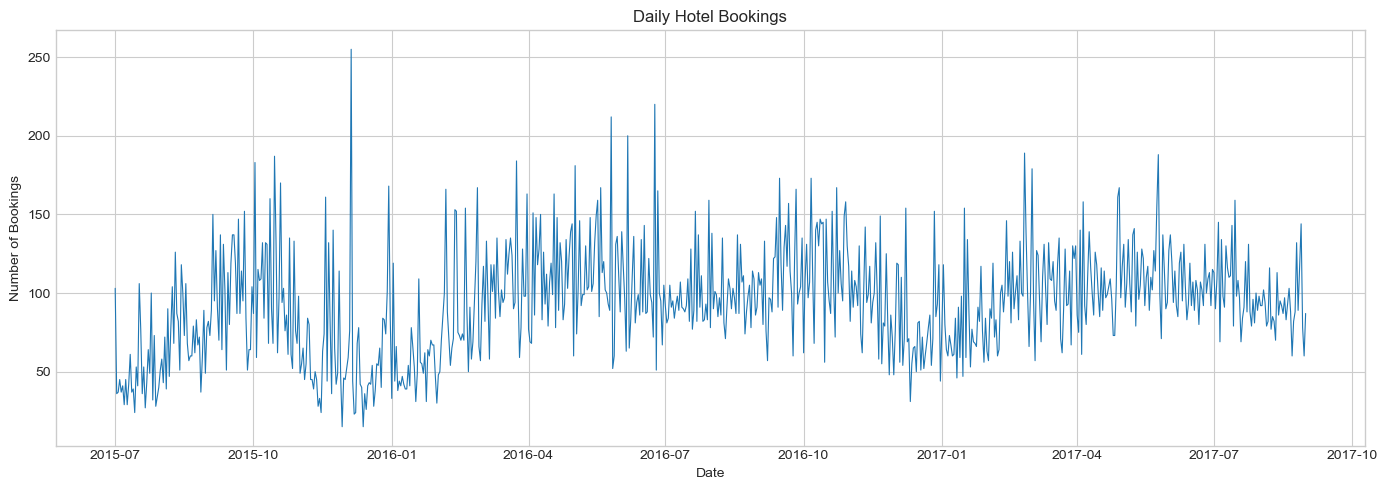

In [3]:
# Plot daily bookings
plt.figure(figsize=(14, 5))
plt.plot(ts_data['ds'], ts_data['y'], linewidth=0.8)
plt.title('Daily Hotel Bookings')
plt.xlabel('Date')
plt.ylabel('Number of Bookings')
plt.tight_layout()
plt.show()

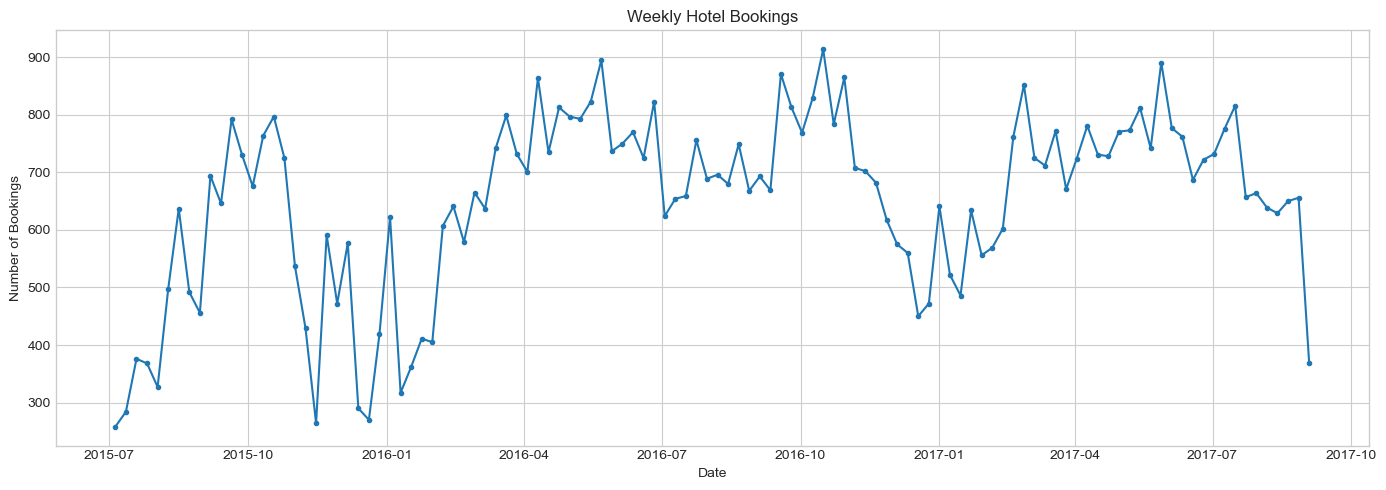

In [4]:
# Resample to weekly for clearer trend
ts_weekly = ts_data.set_index('ds').resample('W')['y'].sum().reset_index()

plt.figure(figsize=(14, 5))
plt.plot(ts_weekly['ds'], ts_weekly['y'], marker='o', markersize=3)
plt.title('Weekly Hotel Bookings')
plt.xlabel('Date')
plt.ylabel('Number of Bookings')
plt.tight_layout()
plt.show()

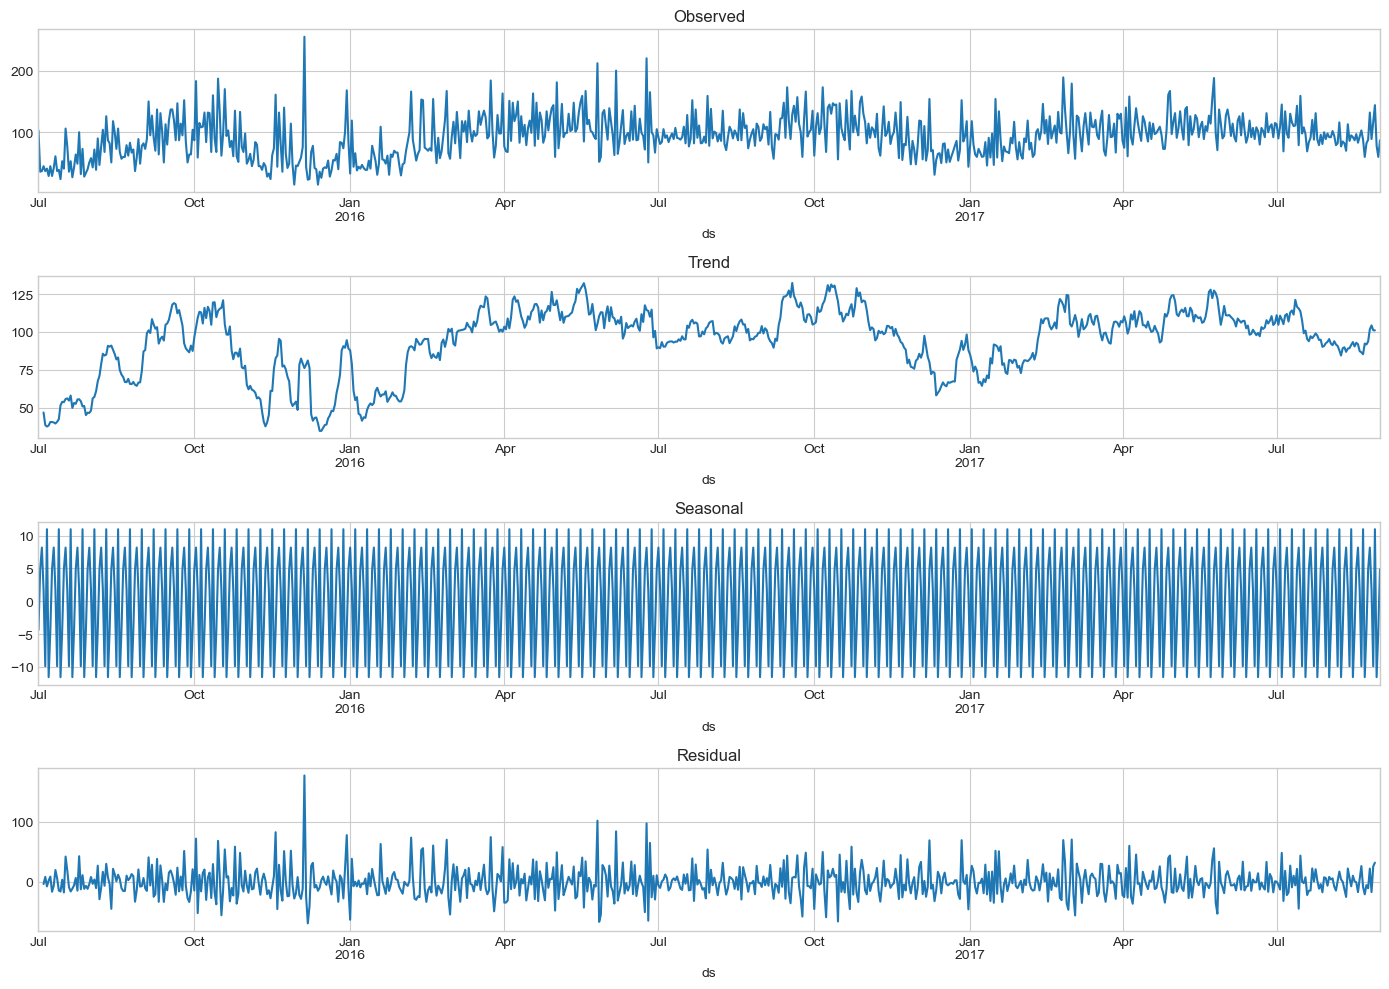

In [5]:
# Seasonal decomposition
ts_indexed = ts_data.set_index('ds')['y']
decomposition = seasonal_decompose(ts_indexed, model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

## 3. ACF & PACF Analysis

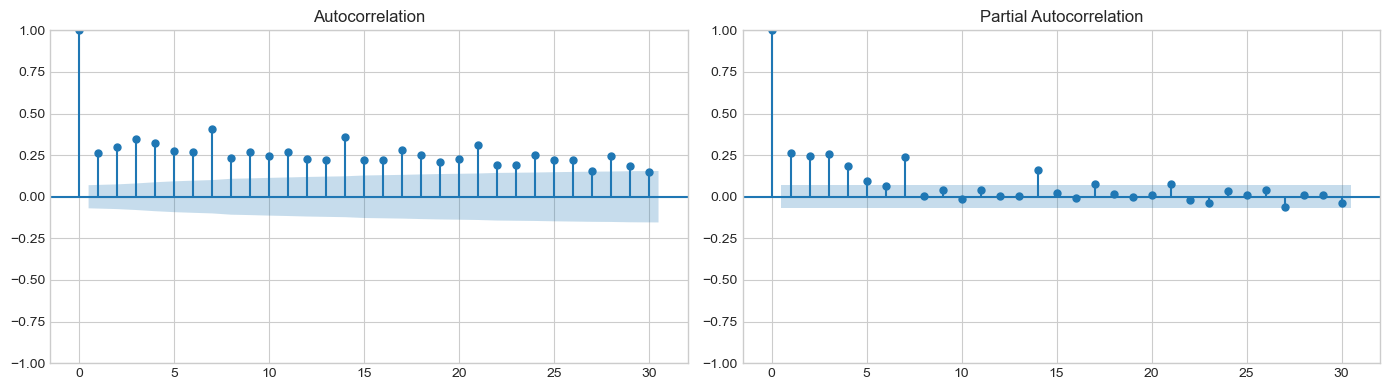

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(ts_indexed.dropna(), ax=axes[0], lags=30)
plot_pacf(ts_indexed.dropna(), ax=axes[1], lags=30)
plt.tight_layout()
plt.show()

## 4. Train/Test Split

Training: 634 days (2015-07-01 00:00:00 to 2017-03-25 00:00:00)
Testing: 159 days (2017-03-26 00:00:00 to 2017-08-31 00:00:00)


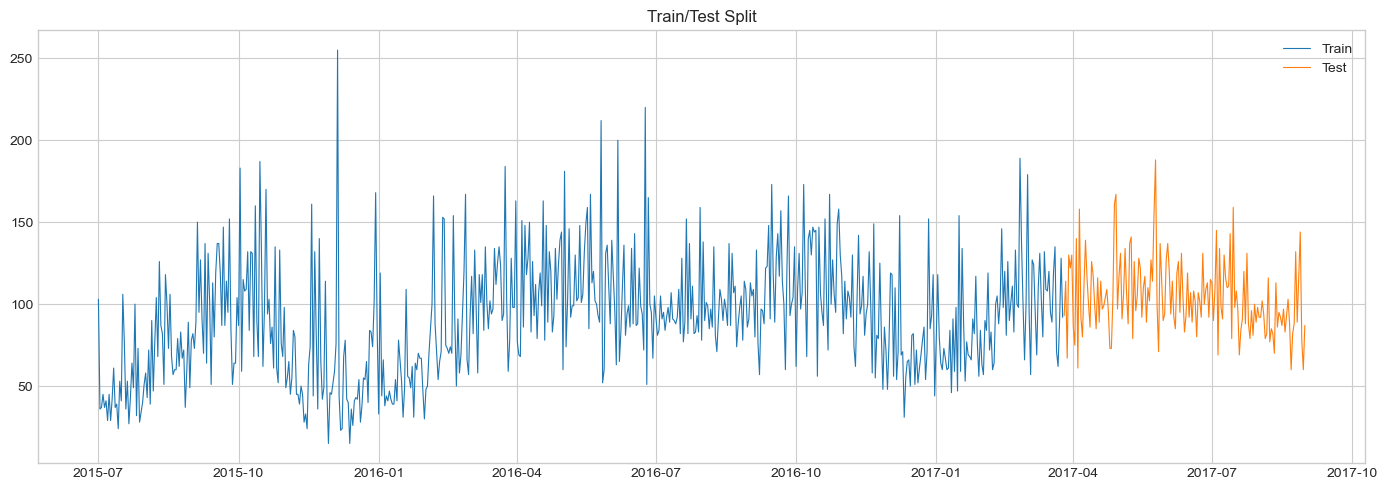

In [7]:
# Time-based split (80/20)
train_size = int(len(ts_data) * 0.8)
train_df = ts_data.iloc[:train_size]
test_df = ts_data.iloc[train_size:]

print(f"Training: {len(train_df)} days ({train_df['ds'].min()} to {train_df['ds'].max()})")
print(f"Testing: {len(test_df)} days ({test_df['ds'].min()} to {test_df['ds'].max()})")

# Visualize split
plt.figure(figsize=(14, 5))
plt.plot(train_df['ds'], train_df['y'], label='Train', linewidth=0.8)
plt.plot(test_df['ds'], test_df['y'], label='Test', linewidth=0.8)
plt.title('Train/Test Split')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Train ARIMA Model

In [8]:
# Train ARIMA
print("Training ARIMA model...")
arima = DemandForecaster(model_type='arima')
arima.train(train_df)

# Evaluate
print("\nEvaluating on test set:")
arima_metrics = arima.evaluate(test_df)

Training ARIMA model...
ARIMA AIC: 6158.27

Evaluating on test set:

=== Time Series Evaluation ===
MAE:  17.82
RMSE: 22.76
MAPE: 17.20%


In [9]:
# Train SARIMA (with weekly seasonality)
print("Training SARIMA model...")
sarima = DemandForecaster(model_type='sarima')
sarima.train(train_df)

# Evaluate
print("\nEvaluating on test set:")
sarima_metrics = sarima.evaluate(test_df)

Training SARIMA model...
SARIMA AIC: 6069.35

Evaluating on test set:

=== Time Series Evaluation ===
MAE:  18.71
RMSE: 23.83
MAPE: 18.82%


## 6. Model Comparison

In [10]:
# Compare models
comparison = pd.DataFrame({
    'ARIMA': arima_metrics,
    'SARIMA': sarima_metrics
}).T

comparison.style.background_gradient(cmap='Reds_r', axis=0)

,mae,rmse,mape
ARIMA,17.823935,22.764169,17.198905
SARIMA,18.709698,23.829156,18.821819


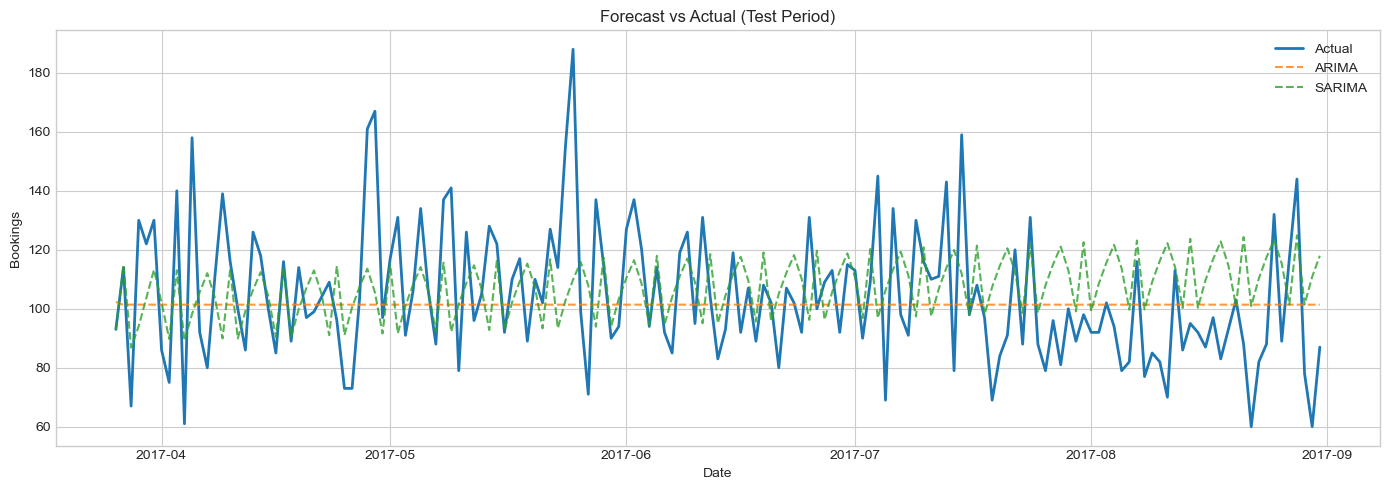

In [11]:
# Visualize forecasts vs actual
forecast_arima = arima.predict(len(test_df))
forecast_sarima = sarima.predict(len(test_df))

plt.figure(figsize=(14, 5))
plt.plot(test_df['ds'].values, test_df['y'].values, label='Actual', linewidth=2)
plt.plot(forecast_arima['ds'].values, forecast_arima['yhat'].values, 
         label='ARIMA', linestyle='--', alpha=0.8)
plt.plot(forecast_sarima['ds'].values, forecast_sarima['yhat'].values, 
         label='SARIMA', linestyle='--', alpha=0.8)

plt.title('Forecast vs Actual (Test Period)')
plt.xlabel('Date')
plt.ylabel('Bookings')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Forecast Future Demand

In [12]:
# Retrain on full data
print("Retraining ARIMA on full dataset...")
final_model = DemandForecaster(model_type='arima')
final_model.train(ts_data)

# Forecast next 30 days
future_forecast = final_model.predict(periods=30)

print("\nNext 30 Days Forecast:")
future_forecast

Retraining ARIMA on full dataset...
ARIMA AIC: 7621.76

Next 30 Days Forecast:


,ds,yhat,yhat_lower,yhat_upper
0,2017-09-01,93.579486,74.863589,112.295383
1,2017-09-02,92.962290,74.369832,111.554749
2,2017-09-03,93.020187,74.416150,111.624225
3,2017-09-04,93.014756,74.411805,111.617707
4,2017-09-05,93.015265,74.412212,111.618319
5,2017-09-06,93.015218,74.412174,111.618261
6,2017-09-07,93.015222,74.412178,111.618267
7,2017-09-08,93.015222,74.412177,111.618266
8,2017-09-09,93.015222,74.412177,111.618266
9,2017-09-10,93.015222,74.412177,111.618266


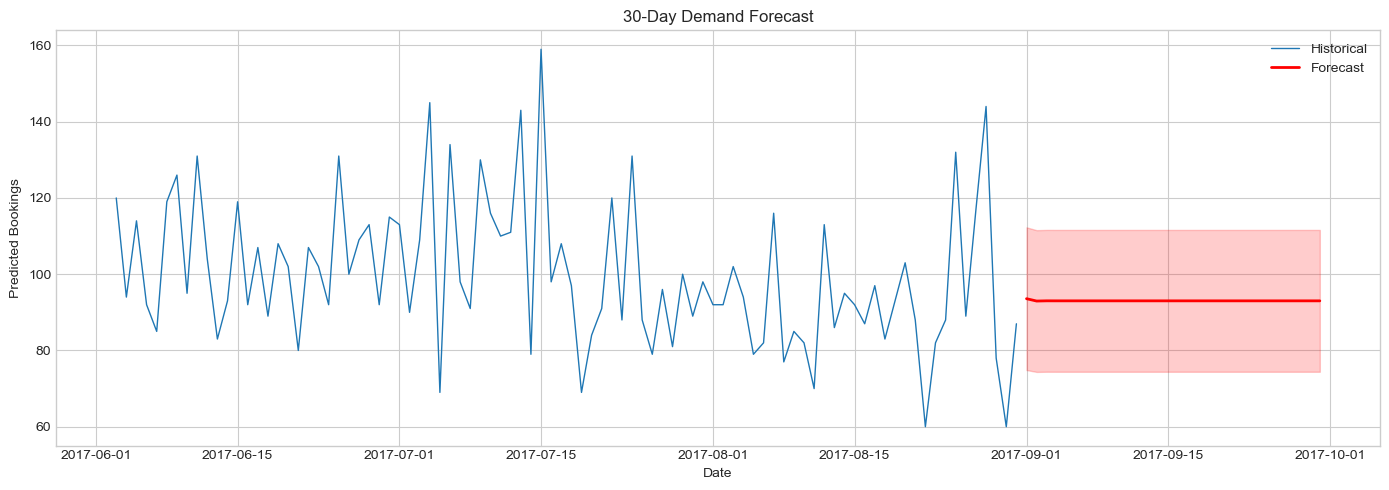

In [13]:
# Visualize future forecast
plt.figure(figsize=(14, 5))

# Historical data (last 90 days)
historical = ts_data.tail(90)
plt.plot(historical['ds'], historical['y'], label='Historical', linewidth=1)

# Forecast
plt.plot(future_forecast['ds'], future_forecast['yhat'], 
         color='red', label='Forecast', linewidth=2)
plt.fill_between(future_forecast['ds'], 
                 future_forecast['yhat_lower'], 
                 future_forecast['yhat_upper'], 
                 alpha=0.2, color='red')

plt.title('30-Day Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Predicted Bookings')
plt.legend()
plt.tight_layout()
plt.show()

## 8. Save Model

In [14]:
# Save the final model
final_model.save('../models/demand_model.pkl')

print("Time series model saved successfully!")

Model saved to ../models/demand_model.pkl
Time series model saved successfully!


In [15]:
# Re-save model with updated serialization format (Prophet JSON)
import importlib
import sys

# Reload the module to get the updated save method
if 'time_series_model' in sys.modules:
    del sys.modules['time_series_model']

from time_series_model import DemandForecaster

# Re-create and train the model
final_model_v2 = DemandForecaster(model_type='prophet')
final_model_v2.fit(train_df)

# Save with new format
final_model_v2.save('../models/demand_model.pkl')
print("Model re-saved with new serialization format!")

AttributeError: 'DemandForecaster' object has no attribute 'fit'